In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [44]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [45]:
ID_COL, TARGET_COL = 'Loan_ID', 'Loan_Status'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Credit_History', 'Property_Area']

num_cols = [c for c in features if c not in cat_cols]

df = pd.concat([train, test], axis=0).reset_index(drop = True)

# Missing Value Imputations

In [46]:
na_cols = [x for x in df.columns if df[x].isnull().sum()>0 and x not in TARGET_COL]

missing_df = df[na_cols]
num_missing_cols = [x for x in na_cols if x in num_cols]

def nan_imputer(df,variable):

    df[variable+"_random"]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample

for col in num_missing_cols:
    nan_imputer(missing_df,col)

df['LoanAmount'] = missing_df['LoanAmount_random']
df['Loan_Amount_Term'] = missing_df['Loan_Amount_Term_random']

df['Gender'].fillna(missing_df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(missing_df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(missing_df['Dependents'].mode()[0],inplace=True)
df['Self_Employed'].fillna(missing_df['Self_Employed'].mode()[0],inplace=True)
df['Credit_History'].fillna(missing_df['Credit_History'].mode()[0],inplace=True)

# Categorical Encoding

In [47]:

df['Gender'] = df['Gender'].map({'Female':0,'Male':1})
df['Married'] = df['Married'].map({'No':0, 'Yes':1})
df['Education'] = df['Education'].map({'Not Graduate':0, 'Graduate':1})
df['Self_Employed'] = df['Self_Employed'].map({'No':0, 'Yes':1})
df['Loan_Status'] = df['Loan_Status'].map({'N':0, 'Y':1})

df['Dependents'] = df['Dependents'].str.rstrip('+')

df['Property_Area'] = df['Property_Area'].map({'Rural':1,'Semiurban':2,'Urban':3})

# Feature Engineering

In [48]:
def emi_calculator(p,  r,  t): 
  
    r = r / (12 * 100)
    emi = (p * r * pow(1 + r, t)) / (pow(1 + r, t) - 1); 
  
    return emi
 

df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

df['Loan_Amount_Term'] = df['Loan_Amount_Term']/12
df['EMI'] = df.apply(lambda emi : emi_calculator(emi['LoanAmount']*1000,12,emi['Loan_Amount_Term']),axis=1)

df['EMI_Income_Ratio'] = df['EMI'] / df['Total_Income']

# Feature Selection

In [49]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFpr

## Split the processed dataset back into train and test datasets

In [50]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [52]:
X = train_proc[features]
y = train_proc[TARGET_COL]

### chi2

In [53]:
KBest = SelectKBest(chi2, k=14)
result = KBest.fit_transform(X, y)

chi2_selection = pd.DataFrame(data=features,columns=["Feature"])
chi2_selection['Score'] = KBest.scores_
chi2_selection.sort_values(by='Score',ascending=False,inplace=True)
chi2_selection.reset_index(inplace=True)

### f_classif

In [54]:
KBest = SelectKBest(f_classif, k=14)
result = KBest.fit_transform(X, y)

f_classif_selection = pd.DataFrame(data=features,columns=["Feature"])
f_classif_selection['Score'] = KBest.scores_
f_classif_selection.sort_values(by='Score',ascending=False,inplace=True)
f_classif_selection.reset_index(inplace=True)

### SelectFpr

In [55]:
KBest = SelectFpr(f_classif, alpha=0.05)
result = KBest.fit_transform(X, y)

fpr_selection = pd.DataFrame(data=features,columns=["Feature"])
fpr_selection['Score'] = KBest.scores_
fpr_selection.sort_values(by='Score',ascending=False,inplace=True)
fpr_selection.reset_index(inplace=True)

In [56]:
features = list( set(fpr_selection['Feature'].loc[:10]).intersection(set(chi2_selection['Feature'].loc[:10])))

# Split the train set into train and validation sets.

In [57]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1, stratify = train_proc[TARGET_COL])

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

## Scaling

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Models

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

### Logistic

In [61]:
lr = LogisticRegression(random_state = 1)
_ = lr.fit(X_trn, y_trn)

preds_val = lr.predict(X_val)

f1_score(y_val, preds_val)

0.9042553191489361

In [62]:
print(confusion_matrix(y_val, preds_val))
print(classification_report(y_val, preds_val))

[[20 18]
 [ 0 85]]
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69        38
         1.0       0.83      1.00      0.90        85

    accuracy                           0.85       123
   macro avg       0.91      0.76      0.80       123
weighted avg       0.88      0.85      0.84       123



### NaiveBaise

In [64]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_trn, y_trn)
preds_val = lr.predict(X_val)

print(f1_score(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))
print(classification_report(y_val, preds_val))

0.9042553191489361
[[20 18]
 [ 0 85]]
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69        38
         1.0       0.83      1.00      0.90        85

    accuracy                           0.85       123
   macro avg       0.91      0.76      0.80       123
weighted avg       0.88      0.85      0.84       123



## RandomForest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
rf = RandomForestClassifier()
rf.fit(X_trn, y_trn)
preds_val = rf.predict(X_val)

print(f1_score(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))
print(classification_report(y_val, preds_val))

0.8961748633879782
[[22 16]
 [ 3 82]]
              precision    recall  f1-score   support

         0.0       0.88      0.58      0.70        38
         1.0       0.84      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.77      0.80       123
weighted avg       0.85      0.85      0.84       123



### RandomizedSearchCV

In [68]:
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [69]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_random.fit(X_trn, y_trn)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [70]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

### RSTuned RandomForest

In [71]:
rf_tuned = rf_random.best_estimator_
rf_tuned.fit(X_trn, y_trn)
preds_val = rf_tuned.predict(X_val)

print(f1_score(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))
print(classification_report(y_val, preds_val))

0.9081081081081082
[[22 16]
 [ 1 84]]
              precision    recall  f1-score   support

         0.0       0.96      0.58      0.72        38
         1.0       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



### GridSearchCV

In [72]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 70, 80, 90,50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300, 600, 900, 1200]
}

clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3)

In [74]:
grid_search.fit(X_trn, y_trn)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  9.0min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [60, 70, 80, 90, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [300, 600, 900, 1200]},
             verbose=3)

In [75]:
rf_tuned_grid = grid_search.best_estimator_
rf_tuned_grid.fit(X_trn, y_trn)
preds_val = rf_tuned_grid.predict(X_val)

print(f1_score(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))
print(classification_report(y_val, preds_val))

0.9130434782608696
[[23 15]
 [ 1 84]]
              precision    recall  f1-score   support

         0.0       0.96      0.61      0.74        38
         1.0       0.85      0.99      0.91        85

    accuracy                           0.87       123
   macro avg       0.90      0.80      0.83       123
weighted avg       0.88      0.87      0.86       123



In [76]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 600}

#### Submission

In [78]:
y_pred = rf_tuned_grid.predict(X_test)
out = test_proc
out['Loan_Status'] = y_pred
df_final = out.drop(['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Total_Income', 'EMI', 'EMI_Income_Ratio'],axis=1)

df_final['Loan_Status'] = np.where(df_final['Loan_Status']==1,'Y','N')
df_final.to_csv("rf_tuned_pred_grid_3.csv",index=False)

## XGBoost

In [79]:
from xgboost import XGBClassifier

In [80]:
xgb = XGBClassifier()
xgb.fit(X_trn, y_trn)
preds_val = xgb.predict(X_val)

print(f1_score(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))
print(classification_report(y_val, preds_val))

0.8926553672316385
[[25 13]
 [ 6 79]]
              precision    recall  f1-score   support

         0.0       0.81      0.66      0.72        38
         1.0       0.86      0.93      0.89        85

    accuracy                           0.85       123
   macro avg       0.83      0.79      0.81       123
weighted avg       0.84      0.85      0.84       123



#### Submission

In [81]:
y_pred = xgb.predict(X_test)
out = test_proc
out['Loan_Status'] = y_pred
df_final = out.drop(['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Total_Income', 'EMI', 'EMI_Income_Ratio'],axis=1)

df_final['Loan_Status'] = np.where(df_final['Loan_Status']==1,'Y','N')
df_final.to_csv("xgb_norm_pred.csv",index=False)

Accuracy: 84.55%


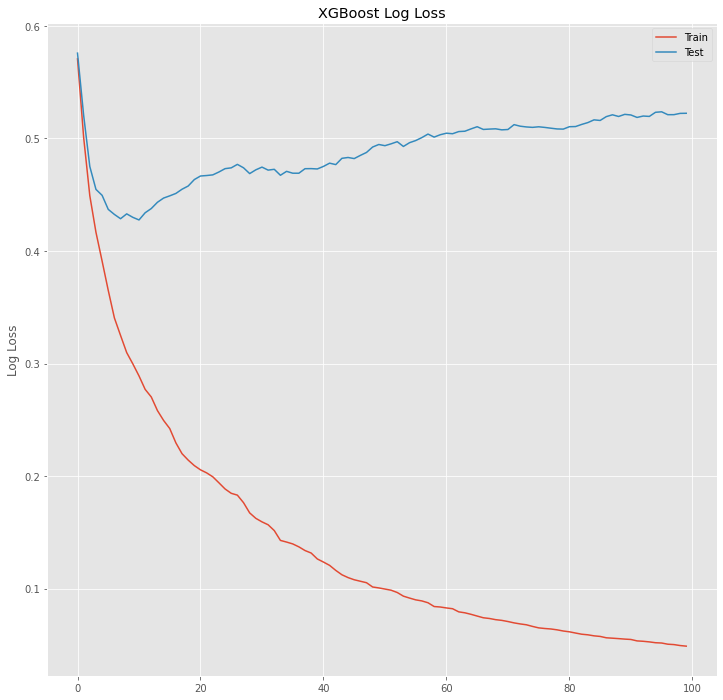

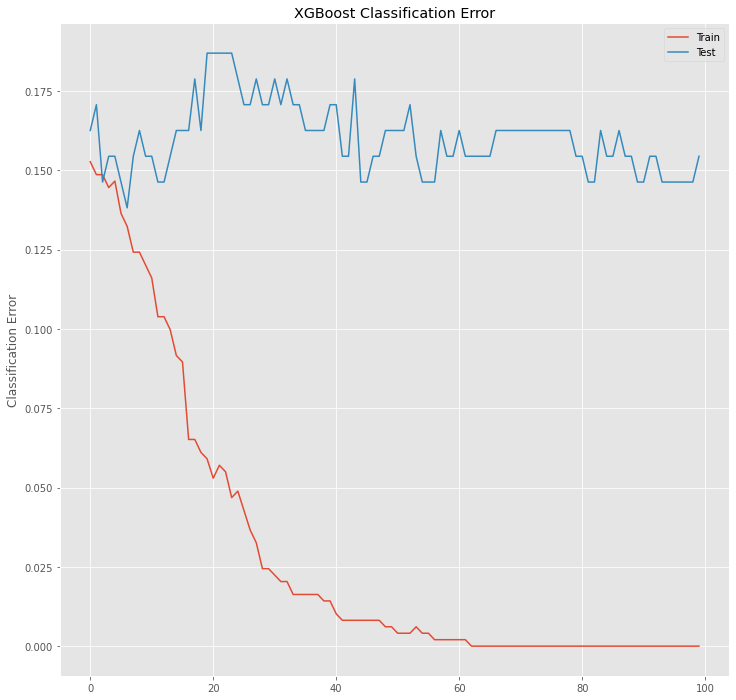

In [84]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import matplotlib.pyplot as plt    

plt.style.use('ggplot')    

# fit model no training data
model = XGBClassifier()
eval_set = [(X_trn, y_trn), (X_val, y_val)]
model.fit(X_trn, y_trn, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()

pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()

pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()